## PART 3: Customer Segmentation with RFM and K-Means

After conducting EDA and cohort analysis, we discovered that customers with a long tenure are the group that has more demand for the business's product. Now, it is time to perform proper customer segmentation to better understand our customer base and present our findings in a more organized and understandable manner for business meetings.

customer segmentation is the process of dividing a customer base into smaller groups based on similar characteristics such as demographics, behaviors, preferences, and needs. This allows businesses to better understand their customers and tailor their marketing strategies and product offerings to meet the specific needs and desires of each segment.

In [1]:
import pandas as pd
import datetime as dt
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf

In [2]:
salesdata = pd.read_csv('Sales_domain.csv', encoding='ISO-8859-1')

In [3]:
salesdata['Date'] = pd.to_datetime(salesdata['Date'], format='%d-%m-%Y')
salesdata['customer_code'] = salesdata['customer_code'].astype(str)

In [4]:
salesdata.head(10)

,Date,product_code,customer_code,sold_quantity,fiscal_year,division,segment,category,product,variant,customer,platform,channel,market,sub_zone,region,gross_price,cost_year,manufacturing_cost,pre_invoice_discount_pct
0,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2018,4.6190,0.0824
1,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2019,4.2033,0.0824
2,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2020,5.0207,0.0824
3,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2021,5.5172,0.0824
4,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2018,4.6190,0.0824
5,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2019,4.2033,0.0824
6,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2020,5.0207,0.0824
7,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2021,5.5172,0.0824
8,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,16.2323,2018,4.6190,0.0824
9,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,16.2323,2019,4.2033,0.0824


## 3.1 Data Transformation

For the segmentation technique, I will be using a simple RFM (Recency, Frequency, Monetary) analysis with an additional T, which stands for Tenure. Since I have observed that the only variable that varies significantly is the total gross revenue generated from each customer, while frequency and recency do not vary much since most clients tend to order at the same time and relatively the same order frequency. The Tenure variable will allow us to identify the customers who have been with us for a long time and potentially have a higher lifetime value.

To prepare the data frame for customer segmentation analysis, I will use SQLite to query each of the recency, purchase frequency, total monetary value, and tenure variables.

In [5]:
query = """
WITH customer_group AS (
  SELECT
    Date,
    customer_code,
    ROUND(SUM((gross_price * sold_quantity) * (1 - pre_invoice_discount_pct)),2) AS gross_sales
  FROM salesdata
  GROUP BY Date, customer_code),
  
snapdate AS (
SELECT DATETIME(MAX(Date), '+1 day') AS snapshotdate
FROM salesdata
)

SELECT 
    customer_code,
    JULIANDAY((SELECT snapshotdate FROM snapdate)) -JULIANDAY(MAX(Date)) AS Recency,
    COUNT(*) AS Frequency,
    ROUND(SUM(gross_sales),2) AS Monatary_value,
    JULIANDAY((SELECT snapshotdate FROM snapdate)) -JULIANDAY(MIN(Date)) AS Tenure
FROM customer_group
GROUP BY customer_code

"""


df_rfm = sqldf(query)

## 3.2 RFM analysis

To perform the RFM analysis, I followed these steps:

- Assigned a score to each variable based on its value, where higher values received higher scores.
- After assigning a score based on each variable value in the RFM analysis, I classified customers into tiers based on their RFM(T) total score.
- Once the customers were assigned their tiers, I looked at the average value of each customer tier.

**Note:** For recency, a lower value indicates better performance, so we will reverse the scoring to ensure higher scores are assigned to customers with lower recency values.

In [6]:
r_labels = range(4,0,-1) #less is better
f_labels = range(1,5) #more is better
m_labels = range(1,5) #more is better
t_labels = range(1,5) #more is better

df_rfm['R_NumberRanks'] = df_rfm['Recency'].rank(method='first')
df_rfm['R'] = df_rfm['R_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = r_labels))

df_rfm['F_NumberRanks'] = df_rfm['Frequency'].rank(method='first')
df_rfm['F'] = df_rfm['F_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = f_labels))

df_rfm['M_NumberRanks'] = df_rfm['Monatary_value'].rank(method='first')
df_rfm['M'] = df_rfm['M_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = m_labels))

df_rfm['T_NumberRanks'] = df_rfm['Tenure'].rank(method='first')
df_rfm['T'] = df_rfm['T_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = t_labels))

In [7]:
def get_segment(data):
    if data['rfmscore'] <= 4:
        return 'tier 4'
    elif data['rfmscore'] <= 8:
        return 'tier 3'
    elif data['rfmscore'] <= 12:
        return 'tier 2'
    else:
        return 'tier 1'

In [8]:
df_rfm = df_rfm[['Recency', 'Frequency', 'Monatary_value', 'Tenure', 'R','F','M','T']]
df_rfm['rfmscore'] = df_rfm[['R','F','M','T']].sum(axis=1)
df_rfm['tier'] = df_rfm.apply(get_segment, axis=1)

In [9]:
df_rfm.groupby('tier').agg(Average_Recency = ('Recency', 'mean'),
                          Average_Frequency = ('Frequency', 'mean'),
                          Average_Monatary_value = ('Monatary_value', 'mean'),
                           Average_Tenure = ('Tenure', 'mean'),
                           Customer_Count = ('Tenure', 'count')).round()

,Average_Recency,Average_Frequency,Average_Monatary_value,Average_Tenure,Customer_Count
tier,,,,,
tier 1,3.0,39.0,9268249.0,1546.0,64
tier 2,11.0,34.0,3623437.0,1398.0,70
tier 3,8.0,25.0,1307733.0,976.0,66
tier 4,31.0,20.0,796985.0,823.0,9


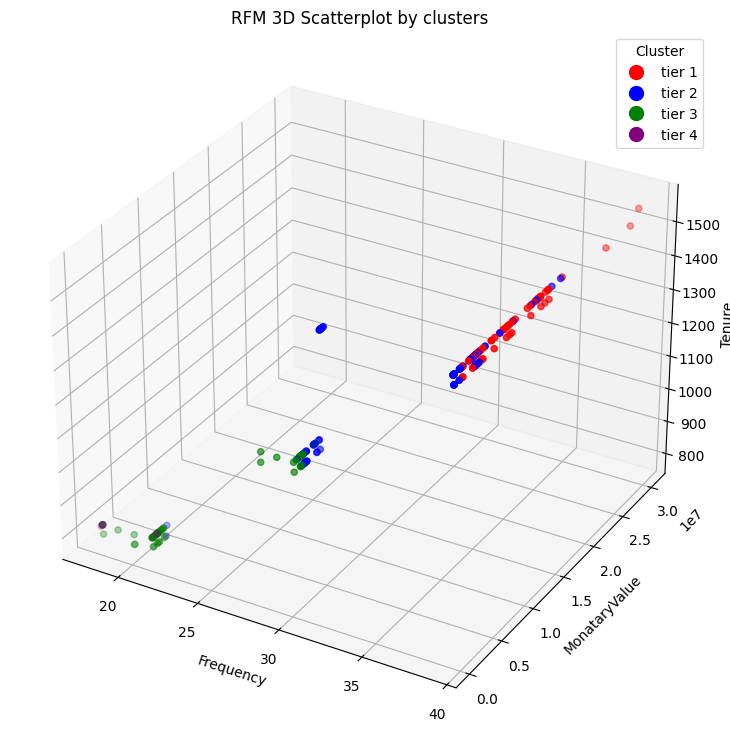

In [12]:
# Define a dictionary to map each tier to a color
color_dict = {'tier 1': 'red', 'tier 2': 'blue', 'tier 3': 'green', 'tier 4': 'purple'}

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(211, projection='3d')
# Map the 'tier' column to colors using the dictionary
scatter  = ax.scatter(df_rfm['Frequency'],df_rfm['Monatary_value'], df_rfm['Tenure'], c=df_rfm['tier'].map(color_dict))
ax.set_xlabel('Frequency')
ax.set_ylabel('MonataryValue')
ax.set_zlabel('Tenure')

# Use the same dictionary to create a legend
handles = [plt.plot([],[],color=color_dict[key], marker="o", ls="", markersize=10)[0] for key in color_dict]
labels = color_dict.keys()
ax.legend(handles, labels, title='Cluster')

plt.title('RFM 3D Scatterplot by clusters')
plt.show()

The most prominent customer segment would be Tier 1, which has the best score in all variables. We can observe that Tier 1 customers have more recent purchases, relatively high order frequency, monetary value, and tenure. These customers seem to have been with the business since 2017, and according to the cohort analysis in part 2, we can see that these customers have significantly increased their order size in their most recent order, which subsequently increases the average monetary value of this customer group.